#Bi-Encoders, Cross-Encoders and ColBERT
Made by: Wilfredo Aaron Sosa Ramos

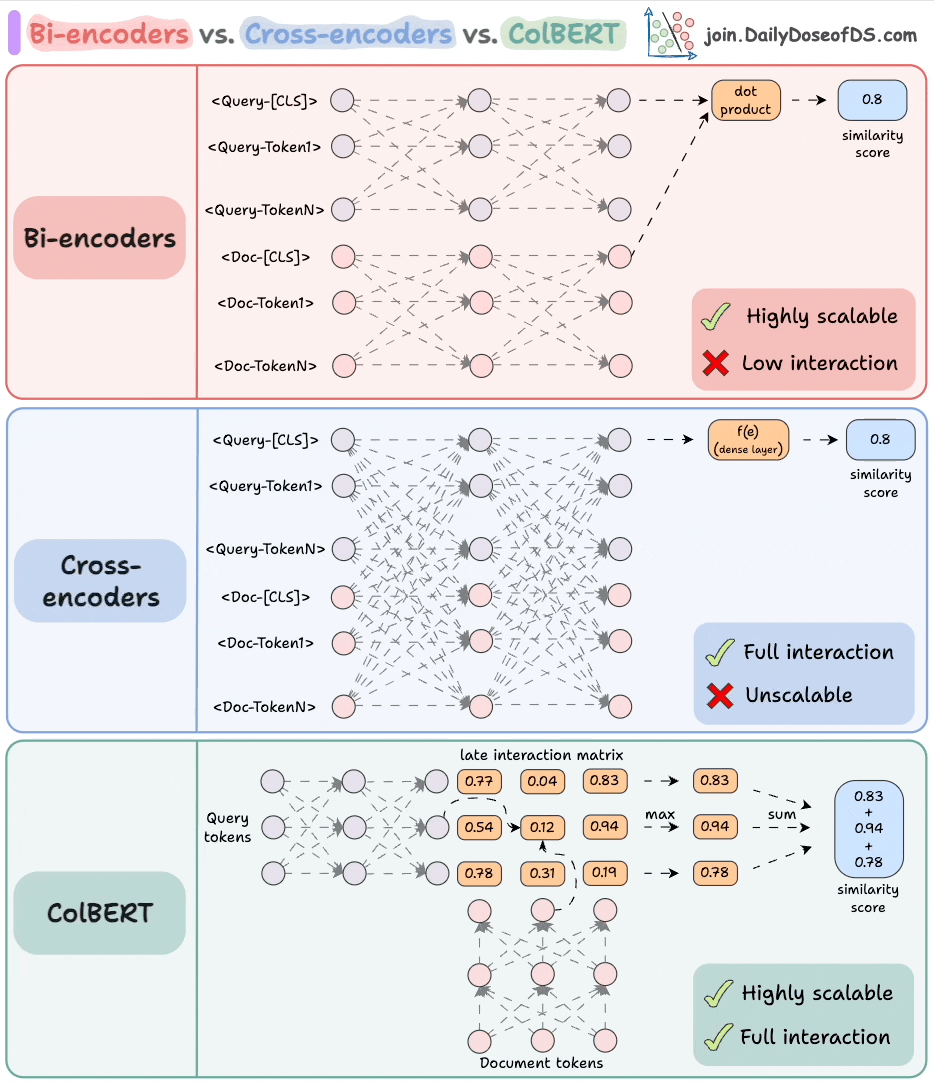

#1. Bi-Encoders

Description:

Bi-Encoders encode queries and documents separately into dense embeddings. The similarity (e.g., cosine similarity) is calculated between the embeddings. It is efficient and scalable for large datasets.

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained model and tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to encode text
def encode_texts(texts):
    tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings

# Example: Query and documents
query = "What is the capital of France?"
documents = ["Paris is the capital of France.", "Berlin is in Germany.", "Madrid is the capital of Spain."]

# Encode query and documents
query_embedding = encode_texts([query])
doc_embeddings = encode_texts(documents)

# Compute cosine similarities
similarities = cosine_similarity(query_embedding, doc_embeddings)
print("Similarities:", similarities)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Similarities: [[0.85606986 0.2803097  0.41691256]]


#2. Cross-Encoders

Description:

Cross-Encoders concatenate the query and document as a single input, allowing the model to compute rich interactions between them. This approach is more accurate but computationally intensive.

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load pre-trained model and tokenizer
model_name = "cross-encoder/nli-deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to calculate scores
def compute_cross_encoder_scores(query, documents):
    scores = []
    for doc in documents:
        inputs = tokenizer(query, doc, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            score = torch.softmax(outputs.logits, dim=1)[0][1].item()  # Prob of being a match
            scores.append(score)
    return scores

# Example: Query and documents
query = "What is the capital of France?"
documents = ["Paris is the capital of France.", "Berlin is in Germany.", "Madrid is the capital of Spain."]

# Compute scores
scores = compute_cross_encoder_scores(query, documents)
print("Scores:", scores)

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/975 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/557M [00:00<?, ?B/s]

Scores: [0.001117134466767311, 0.0005658654263243079, 0.0007911065476946533]


#3. ColBERT (Contextualized Late Interaction)

Description:

ColBERT computes token-level embeddings for queries and documents and uses a late interaction mechanism to calculate similarity. It balances efficiency and rich interactions.

In [3]:
!pip install -q colbert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 8.5 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to encode token-level embeddings
def encode_token_embeddings(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state  # Token-level embeddings

# Late interaction similarity (max-sim)
def late_interaction_similarity(query_embeddings, doc_embeddings):
    scores = torch.matmul(query_embeddings, doc_embeddings.transpose(-1, -2))
    max_sim = scores.max(dim=-1).values
    return max_sim.sum().item()

# Example: Query and documents
query = "What is the capital of France?"
documents = ["Paris is the capital of France.", "Berlin is in Germany.", "Madrid is the capital of Spain."]

# Encode query and document embeddings
query_embeddings = encode_token_embeddings(query)
doc_embeddings_list = [encode_token_embeddings(doc) for doc in documents]

# Compute similarities using late interaction
similarities = [late_interaction_similarity(query_embeddings.squeeze(0), doc_emb.squeeze(0)) for doc_emb in doc_embeddings_list]
print("Similarities:", similarities)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Similarities: [1413.1649169921875, 1194.4727783203125, 1285.0360107421875]


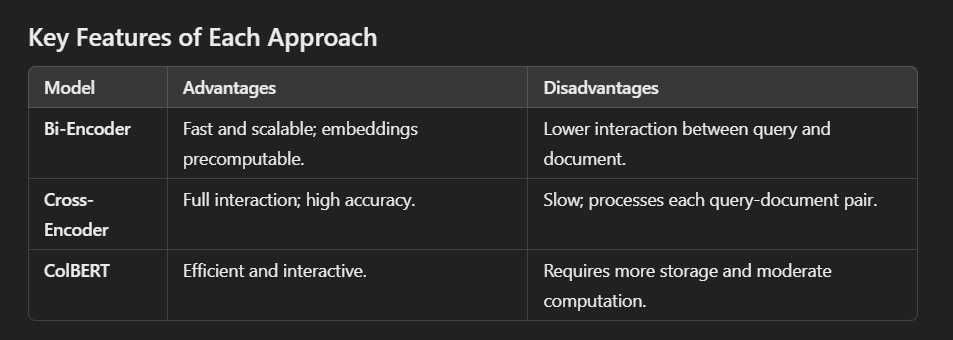